### Calculate percent change in scores

In [2]:
import pandas as pd

In [3]:
def calculate_percent_change(task_id, label_rate1, label_rate2):
    df1 = pd.read_csv(f"../pipeline_results/utility/{task_id}/{task_id}_mixed_{label_rate1}.csv")
    df2 = pd.read_csv(f"../pipeline_results/utility/{task_id}/{task_id}_mixed_{label_rate2}.csv")
    
    df1.set_index('Unnamed: 0', inplace=True)
    df2.set_index('Unnamed: 0', inplace=True)

    # Calculate percent change for each column
    percent_change = round((df2 - df1) / df1, 3)

    # Rename columns to include '_change'
    percent_change.columns = [f"{col}_change" for col in percent_change.columns]

    # Save the output DataFrame to a CSV file
    percent_change.to_csv(f"../pipeline_results/utility/{task_id}/compare_{task_id}_{label_rate1}_{label_rate2}.csv")

    # Display the output DataFrame
    print(percent_change)

In [4]:
task_id = 31941
label_rate1 = "original"
label_rate2 = "0.05"
calculate_percent_change(task_id, label_rate1, label_rate2)

                               Accuracy_change  AUC_change  TPR_change  \
Unnamed: 0                                                               
train_Logistic Regression                0.000       0.000         NaN   
train_Decision Tree                     -0.001      -0.003      -0.016   
train_Random Forest                      0.000       0.006      -0.033   
train_Gradient Boosting                  0.000       0.001      -0.385   
train_XGBoost                            0.000       0.000       0.000   
train_GaussianNB                         0.000       0.000       0.000   
train_ComplementNB                       0.000       0.000       0.000   
train_MultinomialNB                      0.000       0.000       0.000   
train_DNN                                0.000       0.000         NaN   
train_DeepFM                             0.000       0.000         NaN   
holdout_Logistic Regression              0.000       0.000         NaN   
holdout_Decision Tree                 

### Plot TPR Scores (ignore for now)

In [5]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import glob

In [24]:
# Define a function to extract TPR values from a CSV file
def extract_tpr_values(file_path):
    df = pd.read_csv(file_path)
    tpr_data = {'Model': [], 'Task': [], 'TPR': []}
    
    for index, row in df.iterrows():
        task = row[0]
        tpr = row['TPR']
        model = task.split('_', 1)[1]
        
        if task.startswith('train'):
            tpr_data['Task'].append('Train')
        elif task.startswith('holdout'):
            tpr_data['Task'].append('Holdout')
        elif task.startswith('synthetic'):
            label_rate = file_path.split('_')[-1][:-4]
            tpr_data['Task'].append(f'Synthetic_{label_rate}')
        
        tpr_data['Model'].append(model)
        tpr_data['TPR'].append(tpr)
    
    return pd.DataFrame(tpr_data)

In [25]:
# Get all CSV files in the current directory with the given pattern
task_id = 31941
csv_files = glob.glob(f'../pipeline_results/utility/{task_id}/{task_id}_mixed_*.csv')

# Combine TPR data from all files
combined_tpr_data = pd.DataFrame()

for file in csv_files:
    tpr_data = extract_tpr_values(file)
    combined_tpr_data = pd.concat([combined_tpr_data, tpr_data])

/var/folders/_r/6_qzzw511b16y7chkmqr51_80000gn/T/ipykernel_29801/4267281015.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  task = row[0]
/var/folders/_r/6_qzzw511b16y7chkmqr51_80000gn/T/ipykernel_29801/4267281015.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  task = row[0]
/var/folders/_r/6_qzzw511b16y7chkmqr51_80000gn/T/ipykernel_29801/4267281015.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  task = row[0]


In [26]:
combined_tpr_data

,Model,Task,TPR
0,Logistic Regression,Train,0.000
1,Decision Tree,Train,0.258
2,Random Forest,Train,0.182
3,Gradient Boosting,Train,0.026
4,XGBoost,Train,0.138
...,...,...,...
25,GaussianNB,Synthetic_0.05,0.362
26,ComplementNB,Synthetic_0.05,0.604
27,MultinomialNB,Synthetic_0.05,0.452
28,DNN,Synthetic_0.05,0.018


In [ ]:
# Pivot the data for plotting
pivot_df = combined_tpr_data.pivot(index='Model', columns='Task', values='TPR')

# Plot the data
pivot_df.plot(kind='bar', figsize=(15, 8))
plt.title('TPR of Train, Holdout, and Synthetic Tasks')
plt.xlabel('Model')
plt.ylabel('TPR')
plt.xticks(rotation=45)
plt.legend(title='Task')
plt.tight_layout()

In [1]:
def merge_tpr_columns(task_id):
    # Directory containing the CSV files
    directory = f'../pipeline_results/utility/{task_id}'

    # List to hold dataframes
    df_list = []

    # Iterate over all CSV files in the directory
    for filename in os.listdir(directory):
        if filename.endswith(".csv") and filename.startswith(f"{task_id}_mixed"):
            # Extract synthetic path from the filename
            synthetic_path = filename[len(f"{task_id}_mixed_"):]

            # Read the CSV file
            df = pd.read_csv(os.path.join(directory, filename))
            
            # Rename the TPR column to include the synthetic path
            df = df.rename(columns={'TPR': f'TPR_{synthetic_path}'})

            # Append dataframe to the list
            df_list.append(df)
        
    # Merge all dataframes on the 'Model' column
    merged_df = df_list[0]
    for df in df_list[1:]:
        merged_df = merged_df.merge(df, on='Model', how='outer', sort=False)

    # Identify all TPR columns
    tpr_columns = [col for col in merged_df.columns if col.startswith('TPR_')]

    # Separate and sort the TPR columns
    tpr_train = 'TPR_train'
    tpr_holdout = 'TPR_holdout'
    tpr_original = 'TPR_synthetic_original'
    tpr_synthetic = sorted([col for col in tpr_columns if col.startswith('TPR_synthetic_') and col != tpr_original])

    # Final column order: 'Model', 'TPR_train', 'TPR_holdout', 'TPR_synthetic_original', and sorted 'TPR_synthetic_0.0x'
    columns = ['Model'] + [col for col in [tpr_train, tpr_holdout, tpr_original] if col in tpr_columns] + tpr_synthetic

    merged_df = merged_df[['Model'] + columns[1:]]

    # Ensure the order of 'Model' column values remains the same as in the first dataframe
    merged_df = merged_df.set_index('Model').reindex(df_list[0]['Model']).reset_index()
    return merged_df

In [61]:
task_id = 31941
merged_df = merge_tpr_columns(task_id)

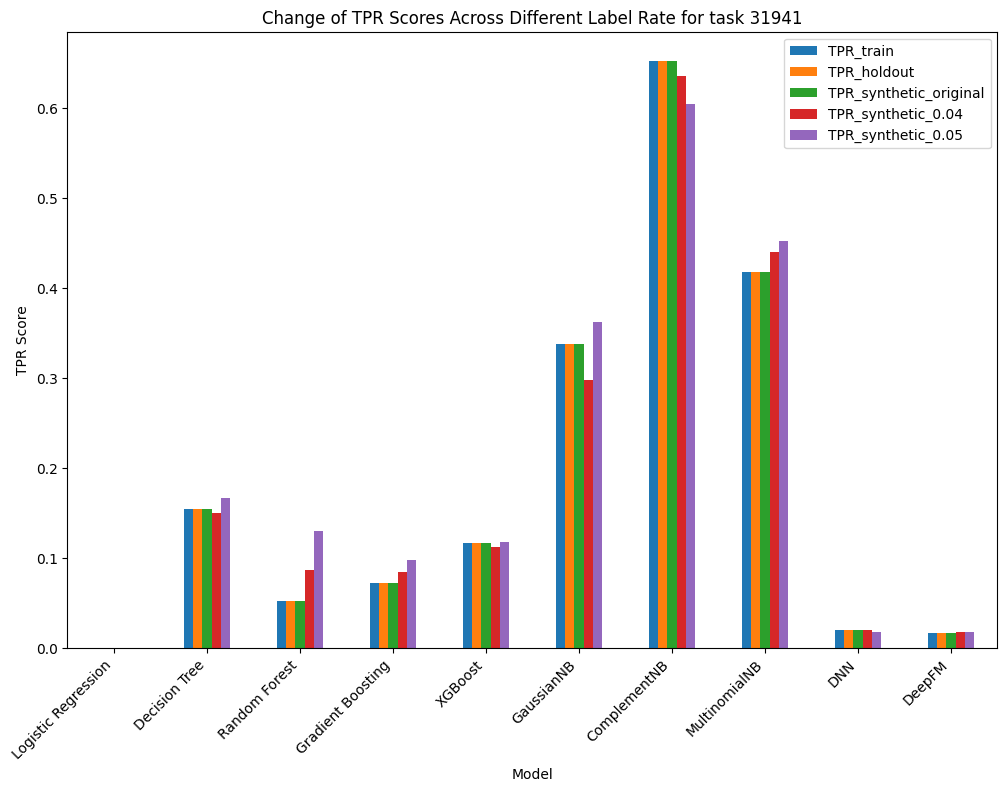

In [62]:
# Set the 'Model' column as the index for easier plotting
merged_df.set_index('Model', inplace=True)

# Plot TPR scores
merged_df.plot(kind='bar', figsize=(12, 8))
plt.ylabel('TPR Score')
# Rotate x-axis labels
plt.xticks(rotation=45, ha='right')
plt.title(f'Change of TPR Scores Across Different Label Rate for task {task_id}')
plt.show()

### Plot Fidelity (Wasserstein Distance)

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [67]:
def merge_fidelity(task_id):
    # Directory containing the CSV files
    directory = f'../pipeline_results/fidelity/{task_id}'

    # List to hold dataframes
    df_list = []

    # Iterate over all CSV files in the directory
    for filename in os.listdir(directory):
        if filename.endswith(".csv") and filename.startswith(f"{task_id}_"):
            # Extract synthetic path from the filename
            synthetic_path = filename[len(f"{task_id}_"):-4]

            # Read the CSV file
            df = pd.read_csv(os.path.join(directory, filename))
            
            # Rename the Wasserstein distance columns to include the synthetic path
            df = df.rename(columns={
                'Wasserstein Distance Label 0': f'W_Distance_Label0_{synthetic_path}',
                'Wasserstein Distance Label 1': f'W_Distance_Label1_{synthetic_path}'
            })

            # Append dataframe to the list
            df_list.append(df)
            
    # Merge all dataframes on the 'Column' column
    merged_df = df_list[0]
    for df in df_list[1:]:
        merged_df = merged_df.merge(df, on='Column', how='outer')

    # Identify all Wasserstein distance columns
    w_columns = [col for col in merged_df.columns if col.startswith('W_Distance_Label')]

    # Separate and sort the distance columns
    w_train = [col for col in w_columns if 'train' in col]
    w_holdout = [col for col in w_columns if 'holdout' in col]
    w_original = [col for col in w_columns if 'synthetic_original' in col]
    w_synthetic = sorted([col for col in w_columns if col not in w_train + w_holdout + w_original])

    # Final column order
    columns = ['Column'] + w_train + w_holdout + w_original + w_synthetic

    # Ensure the order of 'Column' values remains the same as in the first dataframe
    merged_df = merged_df.set_index('Column').reindex(df_list[0]['Column']).reset_index()
    
    # Reorder the columns
    merged_df = merged_df[columns]
    return merged_df

In [75]:
def plot_wasserstein_distances(task_id):
    merged_df = merge_fidelity(task_id)
    
    # Identify columns for each label
    label0_columns = [col for col in merged_df.columns if col.startswith('W_Distance_Label0_')]
    label1_columns = [col for col in merged_df.columns if col.startswith('W_Distance_Label1_')]
    
    # Melt the dataframes for plotting
    df_label0_melted = pd.melt(merged_df, id_vars=['Column'], value_vars=label0_columns, 
                               var_name='Synthetic Path', value_name='Wasserstein Distance')
    df_label1_melted = pd.melt(merged_df, id_vars=['Column'], value_vars=label1_columns, 
                               var_name='Synthetic Path', value_name='Wasserstein Distance')
    
    # Plot for Label 0
    plt.figure(figsize=(15, 8))
    sns.barplot(x='Column', y='Wasserstein Distance', hue='Synthetic Path', data=df_label0_melted)
    plt.xticks(rotation=90)
    plt.title('Wasserstein Distance by Feature and Synthetic Path for Label 0')
    plt.xlabel('Feature')
    plt.ylabel('Wasserstein Distance')
    plt.legend(title='Data w/ Different Label Rate')
    plt.title(f'Wasserstein Distance Across Different Label Rate for task {task_id} Label 0')
    plt.tight_layout()
    plt.show()

    # Plot for Label 1
    plt.figure(figsize=(15, 8))
    sns.barplot(x='Column', y='Wasserstein Distance', hue='Synthetic Path', data=df_label1_melted)
    plt.xticks(rotation=90)
    plt.title('Wasserstein Distance by Feature and Synthetic Path for Label 1')
    plt.xlabel('Feature')
    plt.ylabel('Wasserstein Distance')
    plt.legend(title='Data w/ Different Label Rate')
    plt.title(f'Wasserstein Distance Across Different Label Rate for task {task_id} Label 1')
    plt.tight_layout()
    plt.show()


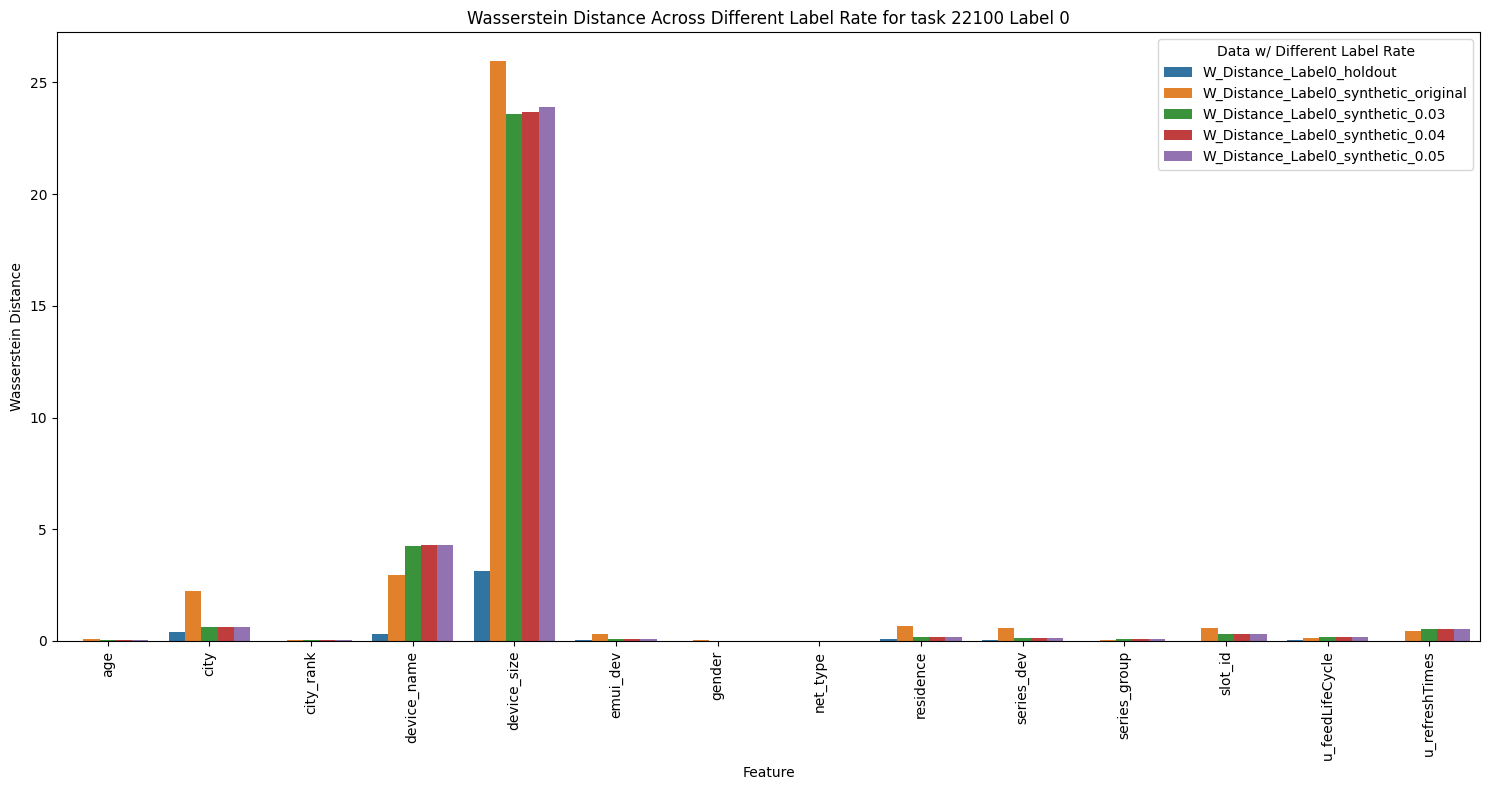

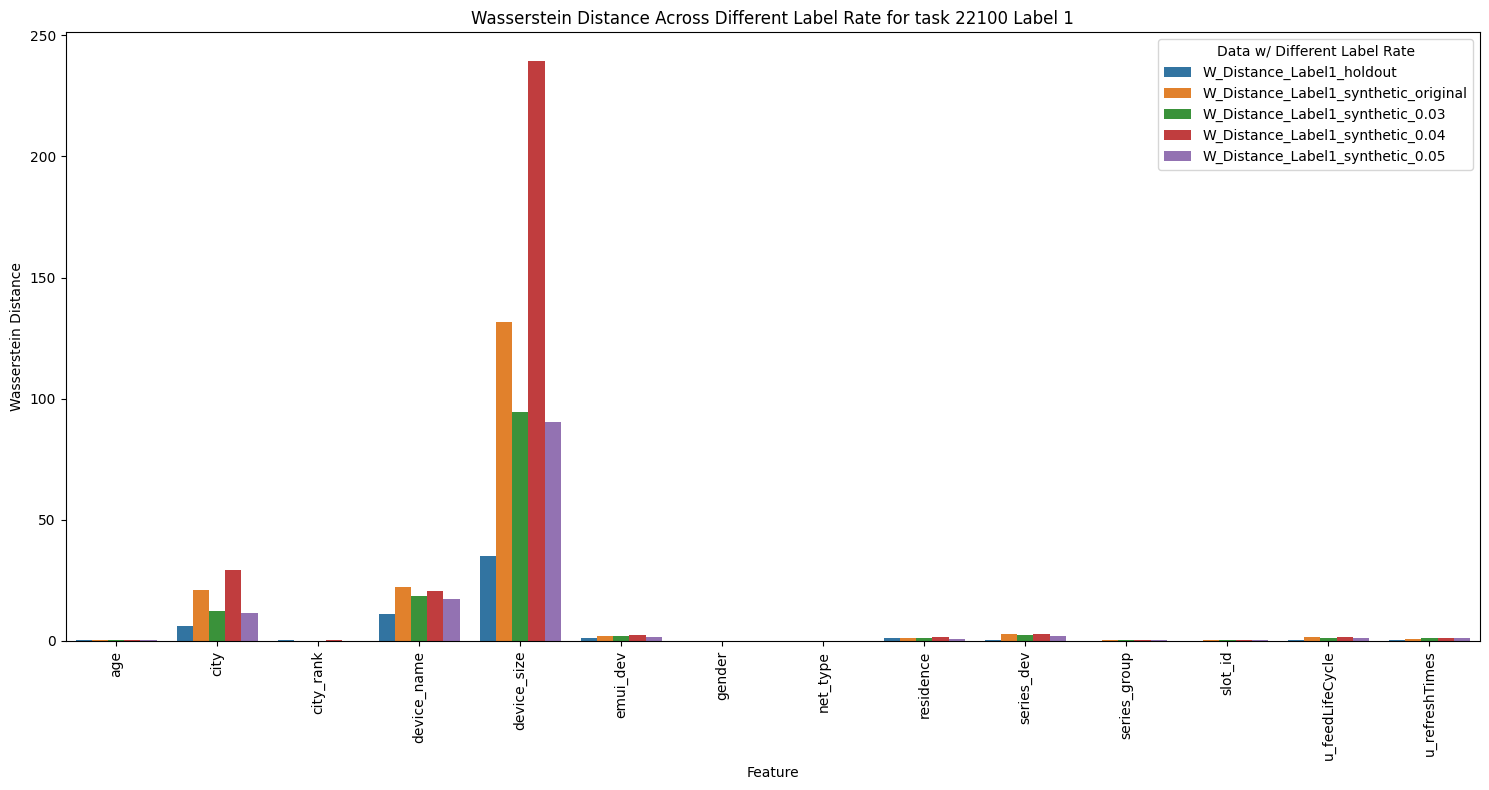

In [78]:
plot_wasserstein_distances(22100)

### Model Fidelity and Utility